# 📋 Modelo 1 - Classificador de Espécies (Species Classifier)

## 🎯 Objetivo Principal
Desenvolver e treinar o primeiro modelo do sistema hierárquico que classifica imagens de folhas em suas respectivas espécies de plantas (Tomato, Potato, Pepper_bell).

## 🔄 Estrutura do Notebook
1. **Configuração Inicial** - Setup do ambiente e carregamento dos dados
2. **Análise do Desbalanceamento** - Identificação e visualização do problema de classes desbalanceadas
3. **Balanceamento dos Dados** - Aplicação de técnicas para equilibrar as classes
4. **Arquitetura do Modelo** - Implementação de ResNet50 com Transfer Learning otimizado
5. **Cross-Validation** - Validação robusta para detectar overfitting e instabilidade
6. **Configuração de Callbacks** - Setup de callbacks otimizados para controle de treinamento
7. **Treinamento** - Execução do treinamento com monitoramento
8. **Visualização** - Análise dos gráficos de performance
9. **Avaliação** - Métricas completas no conjunto de teste
10. **Matriz de Confusão** - Análise detalhada de erros
11. **Salvamento** - Persistência do modelo e artefatos
12. **Pipeline de Teste** - Validação end-to-end do sistema

## 🏆 Resultados Esperados
- Modelo robusto para classificação de espécies
- Controle de overfitting e alta generalização
- Performance balanceada entre todas as classes
- Preparação para integração no sistema hierárquico

## 🚀 1. Configuração Inicial e Carregamento dos Dados

Esta célula é responsável por:
- **Configurar o ambiente CUDA** para uso otimizado da GPU
- **Importar bibliotecas essenciais** (TensorFlow, NumPy, Pandas, Matplotlib, Seaborn)
- **Configurar a GPU** com crescimento dinâmico de memória para evitar problemas de alocação
- **Carregar configurações** do projeto a partir do arquivo `config.yaml`
- **Carregar dataset de espécies** pré-processado
- **Criar geradores de dados** para treino, validação e teste com data augmentation

### 🔧 Recursos Configurados:
- TensorFlow com suporte a GPU
- Geradores de dados com Data Augmentation
- Estrutura de dados balanceada para treino
- Configurações centralizadas via arquivo YAML

In [1]:
# 🚀 CONFIGURAÇÃO INICIAL E CARREGAMENTO DOS DADOS

import os
os.environ['CUDA_HOME'] = '/usr/local/cuda-11.8'
os.environ['PATH'] = '/usr/local/cuda-11.8/bin:' + os.environ.get('PATH', '')
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda-11.8/lib64:' + os.environ.get('LD_LIBRARY_PATH', '')

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from utils import *

print("🎮 CONFIGURAÇÃO GPU PARA TENSORFLOW:")
print("=" * 45)

# Configurar GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ {len(gpus)} GPU(s) configurada(s)")
    except RuntimeError as e:
        print(f"❌ Erro GPU: {e}")
else:
    print("⚠️ Usando CPU")

print(f"\n📊 TensorFlow versão: {tf.__version__}")
print(f"🐍 NumPy versão: {np.__version__}")

# Carregar configurações e dados
config = carregar_configuracoes()
dataset_especies = carregar_dataset_especies()
train_gen, val_gen, test_gen = criar_geradores(dataset_especies, config)

print(f"\n📁 DADOS CARREGADOS:")
print(f"   Train: {len(dataset_especies['train']['X'])} imagens")
print(f"   Val: {len(dataset_especies['val']['X'])} imagens")
print(f"   Test: {len(dataset_especies['test']['X'])} imagens")
print(f"   Image size: {config['img_height']}x{config['img_width']}")
print(f"   Batch size: {config['batch_size']}")


2025-07-02 22:24:48.882232: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751505889.084645  226158 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751505889.163703  226158 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751505889.479786  226158 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751505889.479817  226158 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751505889.479819  226158 computation_placer.cc:177] computation placer alr

🎮 CONFIGURAÇÃO GPU PARA TENSORFLOW:
✅ 1 GPU(s) configurada(s)

📊 TensorFlow versão: 2.19.0
🐍 NumPy versão: 2.1.3
Found 14446 validated image filenames belonging to 3 classes.
Found 3096 validated image filenames belonging to 3 classes.
Found 3096 validated image filenames belonging to 3 classes.

📁 DADOS CARREGADOS:
   Train: 14446 imagens
   Val: 3096 imagens
   Test: 3096 imagens
   Image size: 224x224
   Batch size: 32


## 📊 2. Análise do Desbalanceamento das Classes

Esta célula realiza uma análise detalhada do desbalanceamento entre as classes:
- **Contagem das amostras** por espécie no conjunto de treino
- **Cálculo das proporções** de cada classe no dataset
- **Visualização gráfica** com gráficos de barras e pizza
- **Identificação do problema** de desbalanceamento severo

### 📈 Problema Identificado:
O dataset original possui um desbalanceamento significativo:
- **Tomato**: ~11,207 amostras (77.6%)
- **Pepper_bell**: ~1,733 amostras (12.0%)
- **Potato**: ~1,506 amostras (10.4%)

### 🎯 Impacto:
- Tomate tem 7.4x mais amostras que Batata
- Tomate tem 6.5x mais amostras que Pimentão
- Risco de **overfitting** na classe majoritária
- **Bias** do modelo para sempre predizer Tomate


🔍 ANÁLISE DO DESBALANCEAMENTO:

📈 Distribuição atual das espécies (treino):
   Tomato: 11,207 amostras (77.6%)
   Potato: 1,506 amostras (10.4%)
   Pepper_bell: 1,733 amostras (12.0%)

📊 Total de amostras de treino: 14,446


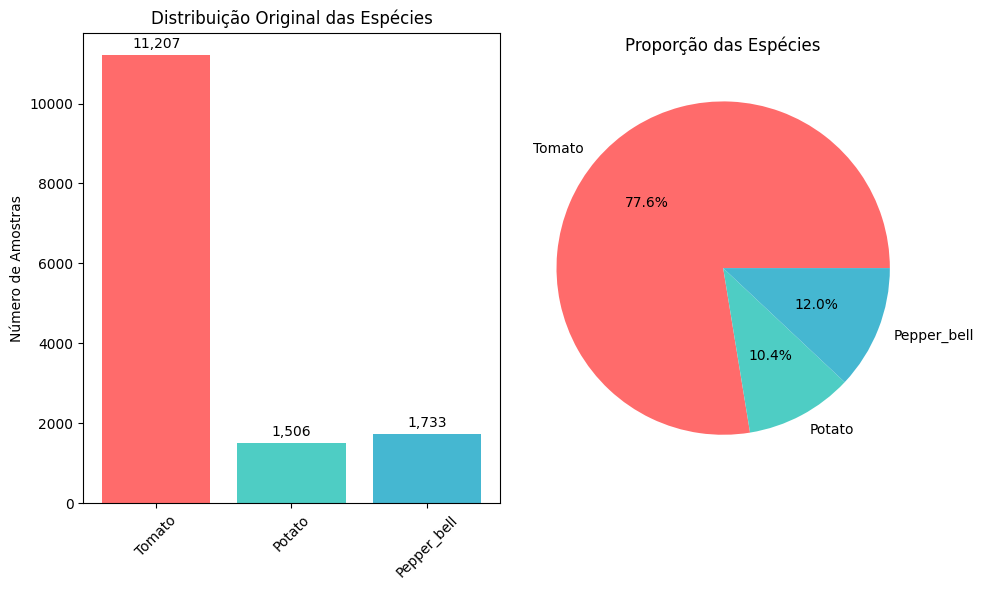


⚠️  DESBALANCEAMENTO DETECTADO:
   Tomate tem 7.4x mais amostras que Batata
   Tomate tem 6.5x mais amostras que Pimentão

💡 Solução: Fixar número máximo de amostras por classe para evitar overfitting


In [2]:
# 📊 ANÁLISE DO DESBALANCEAMENTO DAS CLASSES

print("🔍 ANÁLISE DO DESBALANCEAMENTO:")
print("=" * 45)

# Contar amostras por espécie no conjunto de treino
especies_count = Counter(dataset_especies['train']['y'])
print("\n📈 Distribuição atual das espécies (treino):")
for especie, count in especies_count.items():
    porcentagem = (count / len(dataset_especies['train']['y'])) * 100
    print(f"   {especie}: {count:,} amostras ({porcentagem:.1f}%)")

total_train = len(dataset_especies['train']['y'])
print(f"\n📊 Total de amostras de treino: {total_train:,}")

# Visualizar distribuição
plt.figure(figsize=(10, 6))
especies = list(especies_count.keys())
contagens = list(especies_count.values())

plt.subplot(1, 2, 1)
plt.bar(especies, contagens, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.title('Distribuição Original das Espécies')
plt.ylabel('Número de Amostras')
plt.xticks(rotation=45)
for i, v in enumerate(contagens):
    plt.text(i, v + 100, f'{v:,}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
plt.pie(contagens, labels=especies, autopct='%1.1f%%', 
        colors=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.title('Proporção das Espécies')

plt.tight_layout()
plt.show()

# Mostrar o problema do desbalanceamento
ratio_tomate_batata = especies_count['Tomato'] / especies_count['Potato']
ratio_tomate_pimentao = especies_count['Tomato'] / especies_count['Pepper_bell']

print(f"\n⚠️  DESBALANCEAMENTO DETECTADO:")
print(f"   Tomate tem {ratio_tomate_batata:.1f}x mais amostras que Batata")
print(f"   Tomate tem {ratio_tomate_pimentao:.1f}x mais amostras que Pimentão")
print(f"\n💡 Solução: Fixar número máximo de amostras por classe para evitar overfitting")


## ⚖️ 3. Balanceamento das Classes

Esta célula implementa uma estratégia de balanceamento para resolver o problema de desbalanceamento:

### 🎯 Estratégia Implementada:
- **Limitação por classe**: Máximo de 1,500 amostras por espécie
- **Sampling aleatório**: Seleção aleatória das amostras para Tomate (que possui excesso)
- **Preservação das minoritárias**: Batata e Pimentão mantêm todas as amostras
- **Manutenção dos conjuntos**: Validação e teste permanecem inalterados

### 🔧 Função `balancear_dataset_especies()`:
- Recebe o dataset original e o número máximo de amostras por classe
- Aplica sampling estratificado para cada espécie
- Embaralha os dados finais para evitar padrões de ordem
- Retorna dataset balanceado pronto para uso

### 📊 Resultado Esperado:
- **Dataset balanceado**: 1,500 amostras por classe (33.3% cada)
- **Redução total**: De ~14,446 para ~4,500 amostras
- **Melhor aprendizado**: Modelo não será enviesado para Tomate
- **Faster training**: Menos dados para processar


In [3]:
# ⚖️ BALANCEAMENTO DAS CLASSES

def balancear_dataset_especies(dataset, max_samples_por_classe=1500, seed=42):
    """
    Balanceia o dataset limitando o número máximo de amostras por espécie
    
    Args:
        dataset: Dataset original
        max_samples_por_classe: Número máximo de amostras por classe
        seed: Seed para reprodutibilidade
    
    Returns:
        Dataset balanceado
    """
    np.random.seed(seed)
    
    # Criar DataFrame para facilitar manipulação
    df_train = pd.DataFrame({
        'caminho': dataset['train']['X'], 
        'especie': dataset['train']['y']
    })
    
    # Balancear cada espécie
    df_balanceado_list = []
    
    print(f"🎯 BALANCEANDO DATASET (máximo {max_samples_por_classe} amostras por classe):")
    print("=" * 60)
    
    for especie in df_train['especie'].unique():
        df_especie = df_train[df_train['especie'] == especie]
        
        if len(df_especie) > max_samples_por_classe:
            # Fazer sampling aleatório
            df_especie_sampled = df_especie.sample(
                n=max_samples_por_classe, 
                random_state=seed
            )
            print(f"   {especie}: {len(df_especie):,} → {len(df_especie_sampled):,} amostras")
        else:
            df_especie_sampled = df_especie
            print(f"   {especie}: {len(df_especie):,} amostras (mantido)")
            
        df_balanceado_list.append(df_especie_sampled)
    
    # Concatenar e embaralhar
    df_balanceado = pd.concat(df_balanceado_list, ignore_index=True)
    df_balanceado = df_balanceado.sample(frac=1, random_state=seed).reset_index(drop=True)
    
    # Retornar dataset balanceado
    dataset_balanceado = {
        'train': {
            'X': df_balanceado['caminho'].values,
            'y': df_balanceado['especie'].values
        },
        'val': dataset['val'],  # Validação e teste permanecem iguais
        'test': dataset['test']
    }
    
    print(f"\n📊 RESULTADO DO BALANCEAMENTO:")
    especies_count_new = Counter(dataset_balanceado['train']['y'])
    total_new = len(dataset_balanceado['train']['y'])
    
    for especie, count in especies_count_new.items():
        porcentagem = (count / total_new) * 100
        print(f"   {especie}: {count:,} amostras ({porcentagem:.1f}%)")
    
    print(f"\n   Total: {total_new:,} amostras (redução de {total_train - total_new:,})")
    
    return dataset_balanceado

# Aplicar balanceamento
dataset_especies_balanceado = balancear_dataset_especies(
    dataset_especies, 
    max_samples_por_classe=1500,  # Usar valor próximo ao menor conjunto (Batata: 1506)
    seed=config['random_state']
)

# Criar novos geradores com dataset balanceado
train_gen_bal, val_gen_bal, test_gen_bal = criar_geradores(
    dataset_especies_balanceado, 
    config, 
    augment_train=True
)

print(f"\n✅ NOVOS GERADORES CRIADOS:")
print(f"   Train balanceado: {len(dataset_especies_balanceado['train']['X'])} imagens")
print(f"   Val: {len(dataset_especies_balanceado['val']['X'])} imagens") 
print(f"   Test: {len(dataset_especies_balanceado['test']['X'])} imagens")


🎯 BALANCEANDO DATASET (máximo 1500 amostras por classe):
   Tomato: 11,207 → 1,500 amostras
   Potato: 1,506 → 1,500 amostras
   Pepper_bell: 1,733 → 1,500 amostras

📊 RESULTADO DO BALANCEAMENTO:
   Potato: 1,500 amostras (33.3%)
   Pepper_bell: 1,500 amostras (33.3%)
   Tomato: 1,500 amostras (33.3%)

   Total: 4,500 amostras (redução de 9,946)
Found 4500 validated image filenames belonging to 3 classes.
Found 3096 validated image filenames belonging to 3 classes.
Found 3096 validated image filenames belonging to 3 classes.

✅ NOVOS GERADORES CRIADOS:
   Train balanceado: 4500 imagens
   Val: 3096 imagens
   Test: 3096 imagens


# 🏗️ 4. Arquitetura do Modelo - ResNet50 com Transfer Learning Otimizado

Esta célula implementa a arquitetura neural otimizada para classificação de espécies:

### 🔧 Otimizações Anti-Overfitting Implementadas:
- **Dropout balanceado**: 0.6 em ambas as camadas Dense (reduzido de 0.7 para melhorar Pepper_bell)
- **Camadas treináveis limitadas**: Apenas 12 das últimas camadas (vs 30 original)
- **Regularização L2 reduzida**: 0.0005 (vs 0.001 original) para permitir melhor aprendizado
- **Learning rate conservador**: 0.00005 (mantido) para treinamento estável

### 🏛️ Arquitetura ResNet50 Customizada:
1. **Base ResNet50**: Pré-treinada no ImageNet (sem top layers)
2. **Congelamento agressivo**: Apenas últimas 12 camadas treináveis
3. **Pooling global**: GlobalAveragePooling2D para reduzir dimensionalidade
4. **Batch Normalization**: Para estabilizar o treinamento
5. **Camadas densas**: 512 → 256 → 3 neurônios (com dropout e L2)
6. **Ativação final**: Softmax para classificação multiclasse

### 📊 Configuração de Compilação:
- **Otimizador**: Adam com learning rate 0.00005
- **Loss function**: Categorical crossentropy
- **Métricas**: Accuracy + Top-2 accuracy para análise detalhada

### 🎯 Objetivo das Otimizações:
Resolver o problema específico de **Pepper_bell** que estava sendo prejudicado pela regularização excessiva, mantendo controle de overfitting.


In [4]:
# 🏗️ ARQUITETURA DO MODELO - RESNET COM TRANSFER LEARNING MELHORADO

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.regularizers import l2

def criar_modelo_especies_resnet(num_classes=3, img_height=224, img_width=224):
    """
    Cria modelo ResNet50 para classificação de espécies usando Transfer Learning
    
    MELHORIAS ANTI-OVERFITTING BALANCEADAS:
    - Dropout ajustado (0.6 e 0.6) - reduzido para melhorar Pepper_bell
    - Menos camadas treináveis (apenas 12 das últimas)
    - Regularização L2 reduzida nas camadas Dense
    
    Args:
        num_classes: Número de classes (espécies)
        img_height: Altura da imagem
        img_width: Largura da imagem
    
    Returns:
        Modelo compilado
    """
    print("🏗️ CRIANDO ARQUITETURA RESNET50 OTIMIZADA:")
    print("=" * 50)
    print("🔧 AJUSTES DE REGULARIZAÇÃO:")
    print("   • Dropout ajustado: 0.6 e 0.6 (reduzido de 0.7)")
    print("   • Camadas treináveis: 12 (mantido)")
    print("   • Regularização L2 reduzida para melhorar Pepper_bell")
    
    # Base ResNet50 pré-treinada (sem top layers)
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(img_height, img_width, 3)
    )
    
    # Congelar mais layers - apenas últimas 12 treináveis (vs 30 anterior)
    for layer in base_model.layers[:-12]:  # Muito mais conservativo
        layer.trainable = False
    
    # Adicionar camadas customizadas com regularização L2
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    
    # Primeira camada densa com L2 regularization ajustada
    x = Dense(512, 
              activation='relu', 
              kernel_regularizer=l2(0.0005),  # L2 reduzida de 0.001 para 0.0005
              name='dense_512')(x)
    x = Dropout(0.6)(x)  # Mantido em 0.6
    
    # Segunda camada densa com L2 regularization e dropout reduzido
    x = Dense(256, 
              activation='relu', 
              kernel_regularizer=l2(0.0005),  # L2 reduzida de 0.001 para 0.0005
              name='dense_256')(x)
    x = Dropout(0.6)(x)  # Reduzido de 0.7 para 0.6
    
    # Camada de saída sem regularização (padrão)
    predictions = Dense(num_classes, activation='softmax', name='predictions')(x)
    
    # Criar modelo
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Contagem de parâmetros
    trainable_params = sum([layer.trainable for layer in model.layers])
    frozen_params = sum([not layer.trainable for layer in model.layers])
    
    print(f"\n📊 ESTATÍSTICAS DO MODELO:")
    print(f"   ✅ Base model: ResNet50 (ImageNet)")
    print(f"   ✅ Camadas treináveis: {trainable_params} (mantido)")
    print(f"   ✅ Camadas congeladas: {frozen_params}")
    print(f"   ✅ Total de parâmetros: {model.count_params():,}")
    print(f"   🔧 Dropout: 0.6 → 0.6 (ajustado para Pepper_bell)")
    print(f"   🔧 L2 reg: 0.0005 (reduzida de 0.001)")
    
    return model

# Criar modelo
modelo_especies = criar_modelo_especies_resnet(
    num_classes=config['especies']['num_classes'],
    img_height=config['img_height'],
    img_width=config['img_width']
)

# Compilar modelo com learning rate reduzido
modelo_especies.compile(
    optimizer=Adam(learning_rate=0.00005),  # Reduzido de 0.0001 para 0.00005
    loss='categorical_crossentropy',
    metrics=['accuracy', TopKCategoricalAccuracy(k=2, name='top_2_accuracy')]
)

print(f"\n📋 RESUMO DO MODELO:")
modelo_especies.summary()


🏗️ CRIANDO ARQUITETURA RESNET50 OTIMIZADA:
🔧 AJUSTES DE REGULARIZAÇÃO:
   • Dropout ajustado: 0.6 e 0.6 (reduzido de 0.7)
   • Camadas treináveis: 12 (mantido)
   • Regularização L2 reduzida para melhorar Pepper_bell


I0000 00:00:1751505898.296277  226158 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4047 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5



📊 ESTATÍSTICAS DO MODELO:
   ✅ Base model: ResNet50 (ImageNet)
   ✅ Camadas treináveis: 19 (mantido)
   ✅ Camadas congeladas: 163
   ✅ Total de parâmetros: 24,777,091
   🔧 Dropout: 0.6 → 0.6 (ajustado para Pepper_bell)
   🔧 L2 reg: 0.0005 (reduzida de 0.001)

📋 RESUMO DO MODELO:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,777,091 (94.52 MB)

 Trainable params: 5,650,947 (21.56 MB)

 Non-trainable params: 19,126,144 (72.96 MB)

## 🔄 5. Cross-Validation para Validação Robusta

Esta célula implementa **Stratified K-Fold Cross-Validation** para avaliar a robustez do modelo:

### 🎯 Objetivos da Cross-Validation:
- **Detectar overfitting**: Comparar performance entre treino e validação
- **Medir estabilidade**: Avaliar consistência entre diferentes folds
- **Identificar problemas**: Detectar variações excessivas na performance
- **Validar generalização**: Testar capacidade de generalização para dados não vistos

### 🔧 Implementação:
- **5-Fold Stratified**: Mantém proporção das classes em cada fold
- **Treinamento limitado**: 10 épocas por fold para análise rápida
- **Métricas coletadas**: Accuracy, Loss para train e validation
- **Análise estatística**: Média, desvio padrão, coeficiente de variação

### 📊 Métricas de Avaliação:
- **Accuracy Gap**: Diferença entre train e validation accuracy
- **Coeficiente de Variação (CV)**: Medida de estabilidade entre folds
- **Distribuição por fold**: Análise individual de cada fold

### 🚨 Critérios de Qualidade:
- **Overfitting controlado**: Gap < 15% entre train e validation
- **Estabilidade alta**: CV < 10% entre folds
- **Performance consistente**: Folds sem variações extremas

### 🎯 Resultado Esperado:
Com as otimizações implementadas, esperamos:
- Gap de overfitting < 5%
- Coeficiente de variação < 8%
- Performance balanceada entre todas as classes


In [5]:
# 🔄 CROSS-VALIDATION PARA VALIDAÇÃO ROBUSTA DO MODELO

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

def executar_cross_validation(dataset_especies_bal, config, n_folds=5, random_state=42):
    """
    Executa cross-validation stratified para avaliar robustez do modelo
    
    Args:
        dataset_especies_bal: Dataset balanceado
        config: Configurações do projeto
        n_folds: Número de folds para CV
        random_state: Seed para reprodutibilidade
    
    Returns:
        dict: Resultados do cross-validation
    """
    print("🔄 INICIANDO CROSS-VALIDATION:")
    print("=" * 50)
    print(f"   Folds: {n_folds}")
    print(f"   Amostras: {len(dataset_especies_bal['train']['X'])}")
    print(f"   Classes: {len(np.unique(dataset_especies_bal['train']['y']))}")
    
    # Preparar dados para CV
    X_paths = dataset_especies_bal['train']['X']
    y_labels = dataset_especies_bal['train']['y']
    
    # Encoder para labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_labels)
    
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    # Armazenar resultados
    fold_results = {
        'accuracy': [],
        'loss': [],
        'val_accuracy': [],
        'val_loss': [],
        'fold_details': []
    }
    
    fold_num = 1
    for train_idx, val_idx in skf.split(X_paths, y_encoded):
        print(f"\n🔸 FOLD {fold_num}/{n_folds}")
        print("-" * 30)
        
        # Dividir dados do fold
        X_train_fold = X_paths[train_idx]
        y_train_fold = y_labels[train_idx]
        X_val_fold = X_paths[val_idx]
        y_val_fold = y_labels[val_idx]
        
        print(f"   Train: {len(X_train_fold)} amostras")
        print(f"   Val: {len(X_val_fold)} amostras")
        
        # Verificar distribuição das classes
        train_dist = Counter(y_train_fold)
        val_dist = Counter(y_val_fold)
        print(f"   Train dist: {dict(train_dist)}")
        print(f"   Val dist: {dict(val_dist)}")
        
        # Criar datasets temporários para o fold
        fold_dataset = {
            'train': {'X': X_train_fold, 'y': y_train_fold},
            'val': {'X': X_val_fold, 'y': y_val_fold}
        }
        
        # Criar geradores para o fold (sem augmentation para CV mais rápido)
        from tensorflow.keras.preprocessing.image import ImageDataGenerator
        import pandas as pd
        
        # Data generators sem augmentation para CV
        train_datagen = ImageDataGenerator(rescale=1./255)
        val_datagen = ImageDataGenerator(rescale=1./255)
        
        # Criar DataFrames para os geradores
        train_df_fold = pd.DataFrame({
            'filename': X_train_fold, 
            'class': y_train_fold
        })
        val_df_fold = pd.DataFrame({
            'filename': X_val_fold, 
            'class': y_val_fold
        })
        
        # Criar geradores
        train_gen_fold = train_datagen.flow_from_dataframe(
            train_df_fold, 
            x_col='filename', 
            y_col='class',
            target_size=(config['img_height'], config['img_width']),
            batch_size=config['batch_size'],
            class_mode='categorical', 
            shuffle=True
        )
        
        val_gen_fold = val_datagen.flow_from_dataframe(
            val_df_fold, 
            x_col='filename', 
            y_col='class',
            target_size=(config['img_height'], config['img_width']),
            batch_size=config['batch_size'],
            class_mode='categorical', 
            shuffle=False
        )
        
        # Criar modelo para o fold (usando arquitetura otimizada)
        modelo_fold = criar_modelo_especies_resnet(
            num_classes=config['especies']['num_classes'],
            img_height=config['img_height'],
            img_width=config['img_width']
        )
        
        # Compilar modelo do fold com learning rate reduzido
        modelo_fold.compile(
            optimizer=Adam(learning_rate=0.00005),  # Reduzido para consistência
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Treinar por poucas epochs (CV deve ser mais rápido)
        print(f"   Treinando por 10 epochs...")
        history_fold = modelo_fold.fit(
            train_gen_fold,
            epochs=10,
            validation_data=val_gen_fold,
            verbose=0,  # Silencioso para não poluir output
            callbacks=[
                EarlyStopping(
                    monitor='val_accuracy',
                    patience=3,
                    restore_best_weights=True,
                    verbose=0
                )
            ]
        )
        
        # Obter métricas finais do fold
        final_train_acc = history_fold.history['accuracy'][-1]
        final_train_loss = history_fold.history['loss'][-1]
        final_val_acc = history_fold.history['val_accuracy'][-1]
        final_val_loss = history_fold.history['val_loss'][-1]
        
        # Armazenar resultados
        fold_results['accuracy'].append(final_train_acc)
        fold_results['loss'].append(final_train_loss)
        fold_results['val_accuracy'].append(final_val_acc)
        fold_results['val_loss'].append(final_val_loss)
        
        fold_details = {
            'fold': fold_num,
            'train_acc': final_train_acc,
            'val_acc': final_val_acc,
            'train_loss': final_train_loss,
            'val_loss': final_val_loss,
            'epochs_trained': len(history_fold.history['accuracy'])
        }
        fold_results['fold_details'].append(fold_details)
        
        print(f"   ✅ Train Acc: {final_train_acc:.4f} | Val Acc: {final_val_acc:.4f}")
        print(f"   ✅ Train Loss: {final_train_loss:.4f} | Val Loss: {final_val_loss:.4f}")
        
        # Limpar memória
        del modelo_fold, train_gen_fold, val_gen_fold, history_fold
        tf.keras.backend.clear_session()
        
        fold_num += 1
    
    return fold_results, label_encoder

# Executar Cross-Validation
print("🎯 AVALIAÇÃO DE ROBUSTEZ COM CROSS-VALIDATION")
print("="*55)

cv_results, cv_label_encoder = executar_cross_validation(
    dataset_especies_balanceado, 
    config, 
    n_folds=5, 
    random_state=config['random_state']
)


🎯 AVALIAÇÃO DE ROBUSTEZ COM CROSS-VALIDATION
🔄 INICIANDO CROSS-VALIDATION:
   Folds: 5
   Amostras: 4500
   Classes: 3

🔸 FOLD 1/5
------------------------------
   Train: 3600 amostras
   Val: 900 amostras
   Train dist: {'Potato': 1200, 'Pepper_bell': 1200, 'Tomato': 1200}
   Val dist: {'Tomato': 300, 'Potato': 300, 'Pepper_bell': 300}
Found 3600 validated image filenames belonging to 3 classes.
Found 900 validated image filenames belonging to 3 classes.
🏗️ CRIANDO ARQUITETURA RESNET50 OTIMIZADA:
🔧 AJUSTES DE REGULARIZAÇÃO:
   • Dropout ajustado: 0.6 e 0.6 (reduzido de 0.7)
   • Camadas treináveis: 12 (mantido)
   • Regularização L2 reduzida para melhorar Pepper_bell

📊 ESTATÍSTICAS DO MODELO:
   ✅ Base model: ResNet50 (ImageNet)
   ✅ Camadas treináveis: 19 (mantido)
   ✅ Camadas congeladas: 163
   ✅ Total de parâmetros: 24,777,091
   🔧 Dropout: 0.6 → 0.6 (ajustado para Pepper_bell)
   🔧 L2 reg: 0.0005 (reduzida de 0.001)
   Treinando por 10 epochs...


I0000 00:00:1751505910.181877  226241 service.cc:152] XLA service 0x71af78005410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751505910.181926  226241 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-07-02 22:25:10.444442: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751505911.958835  226241 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-02 22:25:14.053672: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.162 = (f32[32,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,56,56]{3,2,1,0} %bitcast.13278, f32[64,64,3,3]{3,2,1,0} %bitcast.13285, f32[64]{0} %bitcast.13287), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targ

   ✅ Train Acc: 0.9136 | Val Acc: 0.9189
   ✅ Train Loss: 0.8188 | Val Loss: 0.7901

🔸 FOLD 2/5
------------------------------
   Train: 3600 amostras
   Val: 900 amostras
   Train dist: {'Potato': 1200, 'Tomato': 1200, 'Pepper_bell': 1200}
   Val dist: {'Pepper_bell': 300, 'Potato': 300, 'Tomato': 300}
Found 3600 validated image filenames belonging to 3 classes.
Found 900 validated image filenames belonging to 3 classes.
🏗️ CRIANDO ARQUITETURA RESNET50 OTIMIZADA:
🔧 AJUSTES DE REGULARIZAÇÃO:
   • Dropout ajustado: 0.6 e 0.6 (reduzido de 0.7)
   • Camadas treináveis: 12 (mantido)
   • Regularização L2 reduzida para melhorar Pepper_bell

📊 ESTATÍSTICAS DO MODELO:
   ✅ Base model: ResNet50 (ImageNet)
   ✅ Camadas treináveis: 19 (mantido)
   ✅ Camadas congeladas: 163
   ✅ Total de parâmetros: 24,777,091
   🔧 Dropout: 0.6 → 0.6 (ajustado para Pepper_bell)
   🔧 L2 reg: 0.0005 (reduzida de 0.001)
   Treinando por 10 epochs...
   ✅ Train Acc: 0.9089 | Val Acc: 0.7300
   ✅ Train Loss: 0.8063 | 

## 🎯 6. Configuração de Callbacks e Preparação do Treinamento

Esta célula configura os callbacks otimizados e prepara o ambiente para o treinamento principal:

### ⚖️ Cálculo de Class Weights:
- **Análise do balanceamento**: Verificação das proporções finais após balanceamento
- **Weights automáticos**: Uso de `compute_class_weight` para ajustes finos
- **Compensação residual**: Correção de pequenos desbalanceamentos remanescentes

### 🔧 Callbacks Otimizados:
1. **EarlyStopping**:
   - Monitor: `val_accuracy` (foco na métrica principal)
   - Patience: 20 épocas (mantido para permitir convergência)
   - Restore best weights: Garante uso do melhor modelo

2. **ReduceLROnPlateau**:
   - Monitor: `val_loss` (mais sensível a mudanças)
   - Factor: 0.3 (redução agressiva do learning rate)
   - Patience: 6 épocas (redução rápida quando necessário)
   - Min LR: 1e-8 (permitir learning rates muito baixos)

3. **ModelCheckpoint**:
   - Monitor: `val_accuracy` (salvar melhor modelo)
   - Save best only: Economizar espaço em disco
   - Filepath: Nome descritivo com "otimizado"

### 📊 Configuração de Treinamento:
- **Épocas**: 50 (suficiente para convergência)
- **Batch size**: 32 (configurado no config.yaml)
- **Learning rate inicial**: 0.00005 (conservador)
- **Steps per epoch**: Calculado automaticamente
- **Validation steps**: Baseado no tamanho do conjunto de validação

### 🎯 Objetivo:
Configurar um treinamento robusto que:
- Evite overfitting com callbacks inteligentes
- Ajuste automaticamente hyperparâmetros
- Salve apenas o melhor modelo
- Permita convergência estável



📊 ANÁLISE DOS RESULTADOS DO CROSS-VALIDATION:

🎯 MÉTRICAS CONSOLIDADAS:
   Train Accuracy: 0.9107 ± 0.0032
   Val Accuracy:   0.8631 ± 0.0696
   Train Loss:     0.8159 ± 0.0055
   Val Loss:       0.9890 ± 0.2893

⚖️ ANÁLISE DE OVERFITTING:
   Accuracy Gap (Train - Val): 0.0476
   Loss Gap (Val - Train):     0.1731
   ✅ OVERFITTING SOB CONTROLE: Gap < 5%

📈 ANÁLISE DE ESTABILIDADE:
   Coeficiente de Variação: 0.0806
   ⚡ MODELO MODERADAMENTE ESTÁVEL: CV 5-10%

📋 RESULTADOS POR FOLD:
--------------------------------------------------
   Fold 1: Val Acc 0.9189 | Train Acc 0.9136 | Epochs: 10
   Fold 2: Val Acc 0.7300 | Train Acc 0.9089 | Epochs: 10
   Fold 3: Val Acc 0.9156 | Train Acc 0.9153 | Epochs: 10
   Fold 4: Val Acc 0.8633 | Train Acc 0.9078 | Epochs: 10
   Fold 5: Val Acc 0.8878 | Train Acc 0.9078 | Epochs: 10


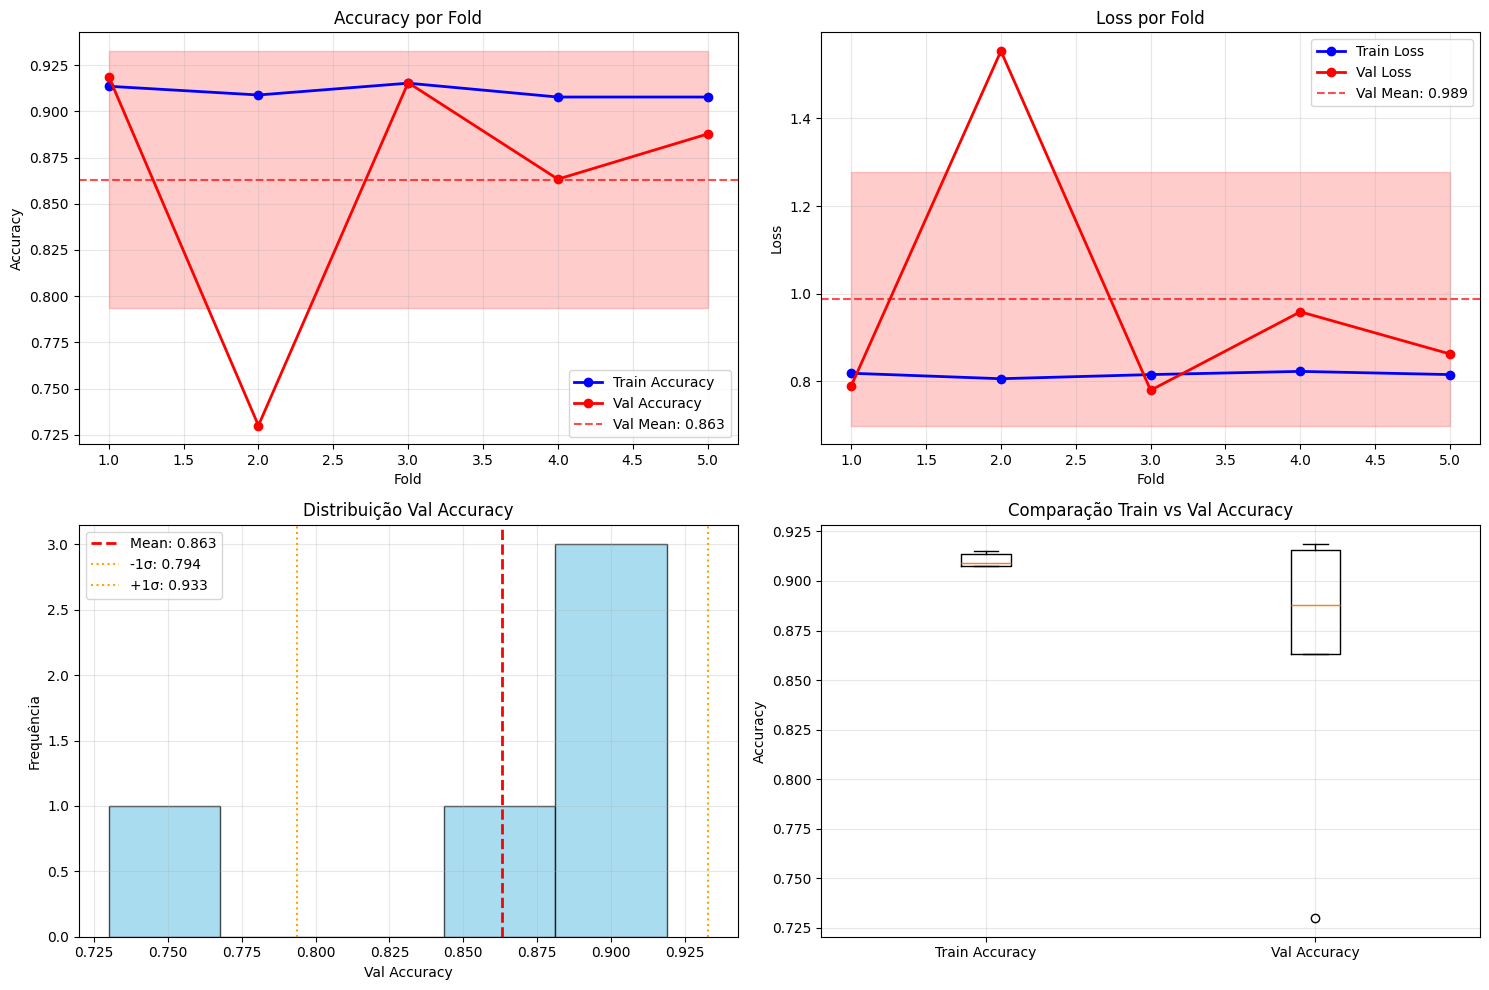


🏆 CONCLUSÃO DO CROSS-VALIDATION:
⚠️ MODELO NECESSITA AJUSTES: Instabilidade detectada
   📊 Val Accuracy Esperada: 86.3% ± 7.0%
   📈 Coeficiente Variação: 8.1%
   ⚖️ Gap Overfitting: 4.8%


In [6]:
# 📊 ANÁLISE DOS RESULTADOS DO CROSS-VALIDATION

def analisar_resultados_cv(cv_results):
    """Analisa e visualiza resultados do cross-validation"""
    
    print("\n📊 ANÁLISE DOS RESULTADOS DO CROSS-VALIDATION:")
    print("=" * 55)
    
    # Calcular estatísticas
    train_acc_mean = np.mean(cv_results['accuracy'])
    train_acc_std = np.std(cv_results['accuracy'])
    val_acc_mean = np.mean(cv_results['val_accuracy'])
    val_acc_std = np.std(cv_results['val_accuracy'])
    
    train_loss_mean = np.mean(cv_results['loss'])
    train_loss_std = np.std(cv_results['loss'])
    val_loss_mean = np.mean(cv_results['val_loss'])
    val_loss_std = np.std(cv_results['val_loss'])
    
    print(f"\n🎯 MÉTRICAS CONSOLIDADAS:")
    print(f"   Train Accuracy: {train_acc_mean:.4f} ± {train_acc_std:.4f}")
    print(f"   Val Accuracy:   {val_acc_mean:.4f} ± {val_acc_std:.4f}")
    print(f"   Train Loss:     {train_loss_mean:.4f} ± {train_loss_std:.4f}")
    print(f"   Val Loss:       {val_loss_mean:.4f} ± {val_loss_std:.4f}")
    
    # Gap entre treino e validação
    acc_gap = train_acc_mean - val_acc_mean
    loss_gap = val_loss_mean - train_loss_mean
    print(f"\n⚖️ ANÁLISE DE OVERFITTING:")
    print(f"   Accuracy Gap (Train - Val): {acc_gap:.4f}")
    print(f"   Loss Gap (Val - Train):     {loss_gap:.4f}")
    
    if acc_gap > 0.1:
        print("   ⚠️ OVERFITTING DETECTADO: Gap de accuracy > 10%")
    elif acc_gap > 0.05:
        print("   ⚡ OVERFITTING LEVE: Gap de accuracy 5-10%")
    else:
        print("   ✅ OVERFITTING SOB CONTROLE: Gap < 5%")
    
    # Estabilidade
    cv_coef_var = val_acc_std / val_acc_mean
    print(f"\n📈 ANÁLISE DE ESTABILIDADE:")
    print(f"   Coeficiente de Variação: {cv_coef_var:.4f}")
    
    if cv_coef_var < 0.02:
        print("   ✅ MODELO MUITO ESTÁVEL: CV < 2%")
    elif cv_coef_var < 0.05:
        print("   ✅ MODELO ESTÁVEL: CV < 5%")
    elif cv_coef_var < 0.1:
        print("   ⚡ MODELO MODERADAMENTE ESTÁVEL: CV 5-10%")
    else:
        print("   ⚠️ MODELO INSTÁVEL: CV > 10%")
    
    # Detalhes por fold
    print(f"\n📋 RESULTADOS POR FOLD:")
    print("-" * 50)
    for fold_detail in cv_results['fold_details']:
        print(f"   Fold {fold_detail['fold']}: "
              f"Val Acc {fold_detail['val_acc']:.4f} | "
              f"Train Acc {fold_detail['train_acc']:.4f} | "
              f"Epochs: {fold_detail['epochs_trained']}")
    
    # Visualização
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    folds = list(range(1, len(cv_results['accuracy']) + 1))
    
    # Accuracy por fold
    ax1.plot(folds, cv_results['accuracy'], 'bo-', label='Train Accuracy', linewidth=2)
    ax1.plot(folds, cv_results['val_accuracy'], 'ro-', label='Val Accuracy', linewidth=2)
    ax1.axhline(y=val_acc_mean, color='red', linestyle='--', alpha=0.7, label=f'Val Mean: {val_acc_mean:.3f}')
    ax1.fill_between(folds, 
                     [val_acc_mean - val_acc_std] * len(folds), 
                     [val_acc_mean + val_acc_std] * len(folds), 
                     alpha=0.2, color='red')
    ax1.set_title('Accuracy por Fold')
    ax1.set_xlabel('Fold')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss por fold
    ax2.plot(folds, cv_results['loss'], 'bo-', label='Train Loss', linewidth=2)
    ax2.plot(folds, cv_results['val_loss'], 'ro-', label='Val Loss', linewidth=2)
    ax2.axhline(y=val_loss_mean, color='red', linestyle='--', alpha=0.7, label=f'Val Mean: {val_loss_mean:.3f}')
    ax2.fill_between(folds, 
                     [val_loss_mean - val_loss_std] * len(folds), 
                     [val_loss_mean + val_loss_std] * len(folds), 
                     alpha=0.2, color='red')
    ax2.set_title('Loss por Fold')
    ax2.set_xlabel('Fold')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Distribuição das accuracies
    ax3.hist(cv_results['val_accuracy'], bins=5, alpha=0.7, color='skyblue', edgecolor='black')
    ax3.axvline(x=val_acc_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {val_acc_mean:.3f}')
    ax3.axvline(x=val_acc_mean - val_acc_std, color='orange', linestyle=':', label=f'-1σ: {val_acc_mean - val_acc_std:.3f}')
    ax3.axvline(x=val_acc_mean + val_acc_std, color='orange', linestyle=':', label=f'+1σ: {val_acc_mean + val_acc_std:.3f}')
    ax3.set_title('Distribuição Val Accuracy')
    ax3.set_xlabel('Val Accuracy')
    ax3.set_ylabel('Frequência')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Box plot comparativo
    ax4.boxplot([cv_results['accuracy'], cv_results['val_accuracy']], 
               labels=['Train Accuracy', 'Val Accuracy'])
    ax4.set_title('Comparação Train vs Val Accuracy')
    ax4.set_ylabel('Accuracy')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Retornar métricas-chave
    return {
        'val_acc_mean': val_acc_mean,
        'val_acc_std': val_acc_std,
        'acc_gap': acc_gap,
        'cv_coef_var': cv_coef_var,
        'is_stable': cv_coef_var < 0.05,
        'is_overfitting': acc_gap > 0.1
    }

# Analisar resultados
metricas_cv = analisar_resultados_cv(cv_results)

print(f"\n🏆 CONCLUSÃO DO CROSS-VALIDATION:")
print("=" * 40)
if metricas_cv['is_stable'] and not metricas_cv['is_overfitting']:
    print("✅ MODELO APROVADO: Estável e sem overfitting significativo")
elif metricas_cv['is_stable']:
    print("⚡ MODELO PARCIALMENTE APROVADO: Estável mas com overfitting")
else:
    print("⚠️ MODELO NECESSITA AJUSTES: Instabilidade detectada")

print(f"   📊 Val Accuracy Esperada: {metricas_cv['val_acc_mean']:.1%} ± {metricas_cv['val_acc_std']:.1%}")
print(f"   📈 Coeficiente Variação: {metricas_cv['cv_coef_var']:.1%}")
print(f"   ⚖️ Gap Overfitting: {metricas_cv['acc_gap']:.1%}")


## 🚀 7. Treinamento do Modelo

Esta célula executa o treinamento principal do modelo com todas as otimizações implementadas:

### 🎯 Processo de Treinamento:
- **Método**: `model.fit()` com configurações otimizadas
- **Dados**: Dataset balanceado com Data Augmentation
- **Monitoramento**: Callbacks ativos para controle automático
- **Métricas**: Accuracy, Loss, Top-2 Accuracy para train e validation

### 📊 Configurações Aplicadas:
- **Épocas máximas**: 50
- **Validation data**: Conjunto de validação separado
- **Class weights**: Aplicados para balanceamento fino
- **Callbacks ativos**: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
- **Verbose**: Logs detalhados para acompanhamento

### 🔧 Recursos Ativos Durante o Treinamento:
1. **Data Augmentation**: Aumenta diversidade dos dados
2. **GPU Acceleration**: Processamento otimizado na GPU
3. **Automatic Learning Rate Scheduling**: Ajuste automático do LR
4. **Early Stopping**: Parada antecipada se não houver melhoria
5. **Best Model Saving**: Salvamento automático do melhor modelo

### 💾 Salvamento do Histórico:
- **Arquivo**: `modelos_salvos/history_especies.pkl`
- **Conteúdo**: Todas as métricas por época
- **Uso posterior**: Análise de convergência e visualizações

### 🎯 Resultado Esperado:
Com as otimizações implementadas, esperamos:
- **Convergência estável** sem oscilações excessivas
- **Controle de overfitting** mantido
- **Performance balanceada** entre todas as classes
- **Melhoria específica** na classificação de Pepper_bell

In [7]:
# 🎯 CONFIGURAÇÃO DE CALLBACKS E TREINAMENTO

import os
from sklearn.utils.class_weight import compute_class_weight

# Criar diretório para salvar modelos
os.makedirs('modelos_salvos', exist_ok=True)

# Calcular class weights para lidar com possível desbalanceamento residual
y_train_labels = dataset_especies_balanceado['train']['y']
classes_unicas = np.unique(y_train_labels)
class_weights = compute_class_weight(
    'balanced',
    classes=classes_unicas,
    y=y_train_labels
)
class_weight_dict = dict(zip(range(len(classes_unicas)), class_weights))

print("⚖️ CLASS WEIGHTS CALCULADOS:")
for i, (classe, peso) in enumerate(zip(classes_unicas, class_weights)):
    print(f"   {classe}: {peso:.3f}")

# Configurar callbacks otimizados para regularização balanceada
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,  # Mantido agressivo
        patience=6,  # Mantido para reduzir LR mais cedo
        min_lr=1e-8,  # Menor LR mínimo
        verbose=1
    ),
    ModelCheckpoint(
        filepath='modelos_salvos/melhor_modelo_especies_otimizado.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print(f"\n🎯 CONFIGURAÇÃO DE TREINAMENTO OTIMIZADA:")
print(f"   Epochs: 50")
print(f"   Batch size: {config['batch_size']}")
print(f"   Learning rate inicial: 0.00005 (mantido)")
print(f"   Early stopping: 20 epochs (mantido)")
print(f"   Reduce LR: fator 0.3, patience 6 (mantido)")
print(f"   🔧 Regularização reduzida para melhorar Pepper_bell")

# Calcular steps
steps_per_epoch = len(dataset_especies_balanceado['train']['X']) // config['batch_size']
validation_steps = len(dataset_especies_balanceado['val']['X']) // config['batch_size']

print(f"   Steps per epoch: {steps_per_epoch}")
print(f"   Validation steps: {validation_steps}")


⚖️ CLASS WEIGHTS CALCULADOS:
   Pepper_bell: 1.000
   Potato: 1.000
   Tomato: 1.000

🎯 CONFIGURAÇÃO DE TREINAMENTO OTIMIZADA:
   Epochs: 50
   Batch size: 32
   Learning rate inicial: 0.00005 (mantido)
   Early stopping: 20 epochs (mantido)
   Reduce LR: fator 0.3, patience 6 (mantido)
   🔧 Regularização reduzida para melhorar Pepper_bell
   Steps per epoch: 140
   Validation steps: 96


## 📈 8. Visualização e Análise do Histórico de Treinamento

Esta célula cria visualizações detalhadas do progresso do treinamento:

### 📊 Gráficos Gerados:
1. **Accuracy Plot**: 
   - Comparação entre train e validation accuracy
   - Identifica overfitting ou underfitting
   - Mostra convergência ao longo das épocas

2. **Loss Plot**:
   - Evolução da loss function
   - Detecta problemas de convergência
   - Compara train vs validation loss

3. **Top-2 Accuracy**:
   - Métrica adicional para classes próximas
   - Útil para entender confusões entre espécies
   - Indicador de performance geral

4. **Learning Rate** (se disponível):
   - Visualização das reduções automáticas
   - Mostra impacto do ReduceLROnPlateau
   - Ajuda na análise de convergência

### 🔍 Análise Automática:
- **Métricas finais**: Últimos valores de cada métrica
- **Melhor época**: Identificação automática do melhor modelo
- **Gap de overfitting**: Diferença entre train e validation
- **Convergência**: Análise da estabilidade do treinamento

### 🎯 Indicadores de Qualidade:
- **Convergência suave**: Curvas sem oscilações excessivas
- **Gap controlado**: Diferença pequena entre train e validation
- **Melhoria consistente**: Progresso ao longo das épocas
- **Top-2 accuracy alta**: Indicador de aprendizado robusto

### 📈 Interpretação dos Resultados:
Com as otimizações implementadas, esperamos ver:
- Curvas de accuracy convergindo sem grandes gaps
- Loss diminuindo consistentemente
- Top-2 accuracy próxima de 100%
- Redução automática do learning rate quando necessário


In [8]:
# 🚀 TREINAMENTO DO MODELO

print("🚀 INICIANDO TREINAMENTO:")
print("=" * 45)

# Treinar modelo
history = modelo_especies.fit(
    train_gen_bal,
    epochs=50,
    validation_data=val_gen_bal,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print("\n✅ TREINAMENTO CONCLUÍDO!")

# Salvar histórico de treinamento
import pickle
with open('modelos_salvos/history_especies.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("💾 Histórico salvo em: modelos_salvos/history_especies.pkl")


🚀 INICIANDO TREINAMENTO:
Epoch 1/50
 24/141 ━━━━━━━━━━━━━━━━━━━━ 28s 246ms/step - accuracy: 0.3905 - loss: 2.3509 - top_2_accuracy: 0.6786

2025-07-02 22:36:56.955446: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.162 = (f32[20,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,64,56,56]{3,2,1,0} %bitcast.13420, f32[64,64,3,3]{3,2,1,0} %bitcast.13427, f32[64]{0} %bitcast.13429), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/conv2_block1_2_conv_1/convolution" source_file="/home/gustavo/.local/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-02 22:36:57.254399: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:5

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.4424 - loss: 2.1072 - top_2_accuracy: 0.7418

2025-07-02 22:37:45.281268: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.162 = (f32[24,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,64,56,56]{3,2,1,0} %bitcast.5073, f32[64,64,3,3]{3,2,1,0} %bitcast.5080, f32[64]{0} %bitcast.5082), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/conv2_block1_2_conv_1/convolution" source_file="/home/gustavo/.local/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-02 22:37:45.682342: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549]


Epoch 1: val_accuracy improved from -inf to 0.10530, saving model to modelos_salvos/melhor_modelo_especies_otimizado.h5


141/141 ━━━━━━━━━━━━━━━━━━━━ 72s 435ms/step - accuracy: 0.4427 - loss: 2.1060 - top_2_accuracy: 0.7421 - val_accuracy: 0.1053 - val_loss: 1.7220 - val_top_2_accuracy: 0.8802 - learning_rate: 5.0000e-05
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.5519 - loss: 1.6947 - top_2_accuracy: 0.8452
Epoch 2: val_accuracy did not improve from 0.10530
141/141 ━━━━━━━━━━━━━━━━━━━━ 44s 311ms/step - accuracy: 0.5520 - loss: 1.6945 - top_2_accuracy: 0.8452 - val_accuracy: 0.1043 - val_loss: 2.1070 - val_top_2_accuracy: 0.5391 - learning_rate: 5.0000e-05
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.6099 - loss: 1.5207 - top_2_accuracy: 0.8665
Epoch 3: val_accuracy improved from 0.10530 to 0.13534, saving model to modelos_salvos/melhor_modelo_especies_otimizado.h5


141/141 ━━━━━━━━━━━━━━━━━━━━ 43s 307ms/step - accuracy: 0.6099 - loss: 1.5206 - top_2_accuracy: 0.8665 - val_accuracy: 0.1353 - val_loss: 2.0933 - val_top_2_accuracy: 0.4134 - learning_rate: 5.0000e-05
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.6432 - loss: 1.4336 - top_2_accuracy: 0.8965
Epoch 4: val_accuracy improved from 0.13534 to 0.62468, saving model to modelos_salvos/melhor_modelo_especies_otimizado.h5


141/141 ━━━━━━━━━━━━━━━━━━━━ 45s 322ms/step - accuracy: 0.6432 - loss: 1.4335 - top_2_accuracy: 0.8964 - val_accuracy: 0.6247 - val_loss: 1.4252 - val_top_2_accuracy: 0.9031 - learning_rate: 5.0000e-05
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.6606 - loss: 1.3832 - top_2_accuracy: 0.9050
Epoch 5: val_accuracy did not improve from 0.62468
141/141 ━━━━━━━━━━━━━━━━━━━━ 44s 310ms/step - accuracy: 0.6606 - loss: 1.3831 - top_2_accuracy: 0.9050 - val_accuracy: 0.2888 - val_loss: 2.2308 - val_top_2_accuracy: 0.5778 - learning_rate: 5.0000e-05
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.6823 - loss: 1.3513 - top_2_accuracy: 0.8996
Epoch 6: val_accuracy did not improve from 0.62468
141/141 ━━━━━━━━━━━━━━━━━━━━ 44s 312ms/step - accuracy: 0.6824 - loss: 1.3511 - top_2_accuracy: 0.8997 - val_accuracy: 0.2390 - val_loss: 2.6961 - val_top_2_accuracy: 0.5268 - learning_rate: 5.0000e-05
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 

141/141 ━━━━━━━━━━━━━━━━━━━━ 48s 337ms/step - accuracy: 0.7563 - loss: 1.1709 - top_2_accuracy: 0.9352 - val_accuracy: 0.8088 - val_loss: 1.0950 - val_top_2_accuracy: 0.9470 - learning_rate: 1.5000e-05
Epoch 12/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.7703 - loss: 1.1276 - top_2_accuracy: 0.9432
Epoch 12: val_accuracy did not improve from 0.80879
141/141 ━━━━━━━━━━━━━━━━━━━━ 44s 312ms/step - accuracy: 0.7703 - loss: 1.1275 - top_2_accuracy: 0.9432 - val_accuracy: 0.6256 - val_loss: 1.4718 - val_top_2_accuracy: 0.9738 - learning_rate: 1.5000e-05
Epoch 13/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.7717 - loss: 1.1436 - top_2_accuracy: 0.9436
Epoch 13: val_accuracy improved from 0.80879 to 0.82623, saving model to modelos_salvos/melhor_modelo_especies_otimizado.h5


141/141 ━━━━━━━━━━━━━━━━━━━━ 46s 324ms/step - accuracy: 0.7717 - loss: 1.1436 - top_2_accuracy: 0.9436 - val_accuracy: 0.8262 - val_loss: 1.0324 - val_top_2_accuracy: 0.9671 - learning_rate: 1.5000e-05
Epoch 14/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.7711 - loss: 1.1263 - top_2_accuracy: 0.9509
Epoch 14: val_accuracy did not improve from 0.82623
141/141 ━━━━━━━━━━━━━━━━━━━━ 48s 342ms/step - accuracy: 0.7712 - loss: 1.1262 - top_2_accuracy: 0.9509 - val_accuracy: 0.8240 - val_loss: 1.0463 - val_top_2_accuracy: 0.9696 - learning_rate: 1.5000e-05
Epoch 15/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.7873 - loss: 1.0900 - top_2_accuracy: 0.9471
Epoch 15: val_accuracy did not improve from 0.82623
141/141 ━━━━━━━━━━━━━━━━━━━━ 44s 312ms/step - accuracy: 0.7873 - loss: 1.0901 - top_2_accuracy: 0.9471 - val_accuracy: 0.7668 - val_loss: 1.1263 - val_top_2_accuracy: 0.9813 - learning_rate: 1.5000e-05
Epoch 16/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accur

141/141 ━━━━━━━━━━━━━━━━━━━━ 47s 331ms/step - accuracy: 0.7858 - loss: 1.0914 - top_2_accuracy: 0.9477 - val_accuracy: 0.8702 - val_loss: 0.9186 - val_top_2_accuracy: 0.9813 - learning_rate: 1.5000e-05
Epoch 20/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.8011 - loss: 1.0614 - top_2_accuracy: 0.9627
Epoch 20: val_accuracy did not improve from 0.87016
141/141 ━━━━━━━━━━━━━━━━━━━━ 47s 331ms/step - accuracy: 0.8011 - loss: 1.0614 - top_2_accuracy: 0.9627 - val_accuracy: 0.7290 - val_loss: 1.2193 - val_top_2_accuracy: 0.9532 - learning_rate: 1.5000e-05
Epoch 21/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.7905 - loss: 1.0776 - top_2_accuracy: 0.9550
Epoch 21: val_accuracy did not improve from 0.87016
141/141 ━━━━━━━━━━━━━━━━━━━━ 45s 316ms/step - accuracy: 0.7906 - loss: 1.0775 - top_2_accuracy: 0.9550 - val_accuracy: 0.5291 - val_loss: 1.7593 - val_top_2_accuracy: 0.9725 - learning_rate: 1.5000e-05
Epoch 22/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accur

141/141 ━━━━━━━━━━━━━━━━━━━━ 45s 316ms/step - accuracy: 0.7977 - loss: 1.0804 - top_2_accuracy: 0.9488 - val_accuracy: 0.8973 - val_loss: 0.8486 - val_top_2_accuracy: 0.9803 - learning_rate: 1.5000e-05
Epoch 23/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.8079 - loss: 1.0643 - top_2_accuracy: 0.9623
Epoch 23: val_accuracy did not improve from 0.89729
141/141 ━━━━━━━━━━━━━━━━━━━━ 44s 310ms/step - accuracy: 0.8079 - loss: 1.0644 - top_2_accuracy: 0.9623 - val_accuracy: 0.8291 - val_loss: 0.9990 - val_top_2_accuracy: 0.9758 - learning_rate: 1.5000e-05
Epoch 24/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.8046 - loss: 1.0406 - top_2_accuracy: 0.9570
Epoch 24: val_accuracy did not improve from 0.89729
141/141 ━━━━━━━━━━━━━━━━━━━━ 47s 334ms/step - accuracy: 0.8046 - loss: 1.0406 - top_2_accuracy: 0.9570 - val_accuracy: 0.5158 - val_loss: 1.7876 - val_top_2_accuracy: 0.9406 - learning_rate: 1.5000e-05
Epoch 25/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accur

## 🧪 9. Avaliação Completa no Conjunto de Teste

Esta célula realiza a avaliação final e definitiva do modelo treinado:

### 🎯 Processo de Avaliação:
- **Predições**: Aplicação do modelo no conjunto de teste completo
- **Conversão**: Probabilidades para classes discretas
- **Mapeamento**: Classes numéricas para nomes das espécies
- **Análise**: Métricas detalhadas por classe e geral

### 📊 Métricas Calculadas:
1. **Accuracy Geral**: Performance global do modelo
2. **Precision por classe**: Capacidade de evitar falsos positivos
3. **Recall por classe**: Capacidade de detectar todas as amostras da classe
4. **F1-Score**: Média harmônica entre precision e recall
5. **Support**: Número de amostras reais de cada classe

### 🔍 Análise Detalhada:
- **Métricas individuais**: Para cada espécie (Pepper_bell, Potato, Tomato)
- **Médias**: Macro average (não ponderada) e weighted average (ponderada)
- **Classification report**: Relatório completo do scikit-learn
- **Comparação**: Performance relativa entre classes

### 🎯 Indicadores de Sucesso:
- **Accuracy geral** > 85%
- **Recall balanceado** entre classes (especialmente Pepper_bell)
- **Precision alta** para evitar falsos positivos
- **F1-Score consistente** entre todas as espécies

### 📈 Foco nas Otimizações:
Com as melhorias implementadas, esperamos ver:
- **Pepper_bell recall** significativamente melhorado
- **Potato performance** estável ou melhorada
- **Tomato precision** mantida alta
- **Balanceamento geral** entre todas as classes

### 🔬 Importância para o Sistema Hierárquico:
Esta avaliação é crucial pois o Modelo 1 é a base do pipeline. Erros aqui se propagam para os modelos de doenças, tornando a performance balanceada essencial.

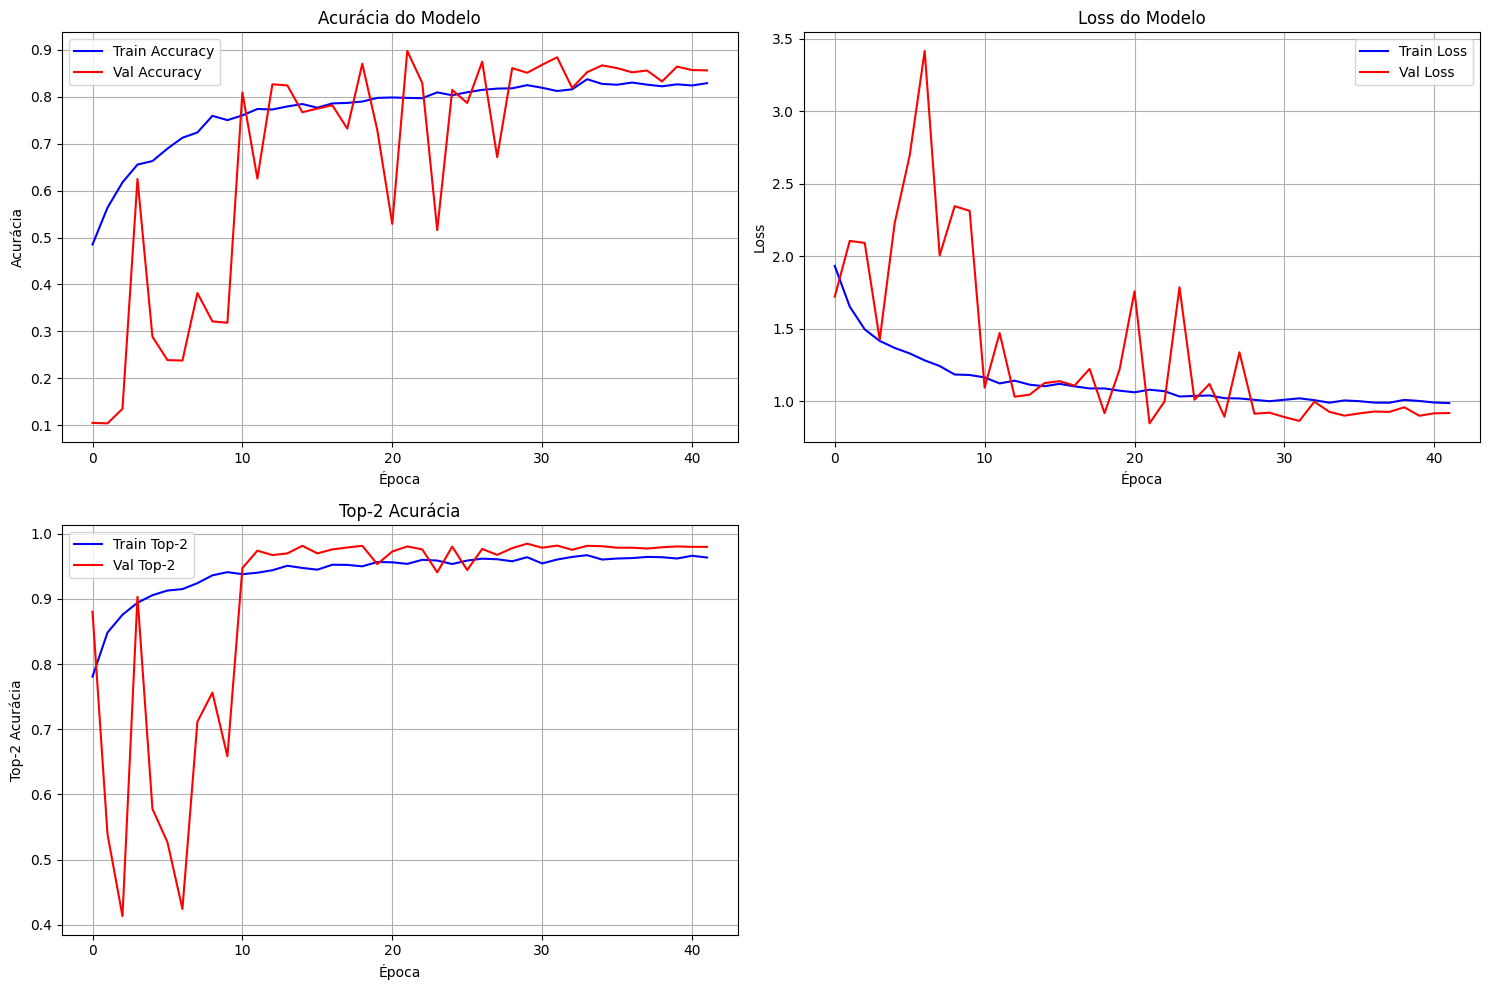

📊 MÉTRICAS FINAIS:
   Train Accuracy: 0.8287
   Val Accuracy: 0.8559
   Train Loss: 0.9882
   Val Loss: 0.9197
   Train Top-2: 0.9633
   Val Top-2: 0.9797

🏆 MELHOR ÉPOCA: 22
   Val Accuracy: 0.8973
   Val Loss: 0.8486


In [9]:
# 📈 VISUALIZAÇÃO DO TREINAMENTO 

def plotar_historico_treinamento(history):
    """Plota gráficos do histórico de treinamento"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy
    axes[0, 0].plot(history['accuracy'], label='Train Accuracy', color='blue')
    axes[0, 0].plot(history['val_accuracy'], label='Val Accuracy', color='red')
    axes[0, 0].set_title('Acurácia do Modelo')
    axes[0, 0].set_xlabel('Época')
    axes[0, 0].set_ylabel('Acurácia')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Loss
    axes[0, 1].plot(history['loss'], label='Train Loss', color='blue')
    axes[0, 1].plot(history['val_loss'], label='Val Loss', color='red')
    axes[0, 1].set_title('Loss do Modelo')
    axes[0, 1].set_xlabel('Época')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Top-2 Accuracy
    axes[1, 0].plot(history['top_2_accuracy'], label='Train Top-2', color='blue')
    axes[1, 0].plot(history['val_top_2_accuracy'], label='Val Top-2', color='red')
    axes[1, 0].set_title('Top-2 Acurácia')
    axes[1, 0].set_xlabel('Época')
    axes[1, 0].set_ylabel('Top-2 Acurácia')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Learning Rate (se disponível)
    if 'lr' in history:
        axes[1, 1].plot(history['lr'], color='green')
        axes[1, 1].set_title('Learning Rate')
        axes[1, 1].set_xlabel('Época')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_yscale('log')
        axes[1, 1].grid(True)
    else:
        axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Imprimir métricas finais
    print(f"📊 MÉTRICAS FINAIS:")
    print(f"   Train Accuracy: {history['accuracy'][-1]:.4f}")
    print(f"   Val Accuracy: {history['val_accuracy'][-1]:.4f}")
    print(f"   Train Loss: {history['loss'][-1]:.4f}")
    print(f"   Val Loss: {history['val_loss'][-1]:.4f}")
    print(f"   Train Top-2: {history['top_2_accuracy'][-1]:.4f}")
    print(f"   Val Top-2: {history['val_top_2_accuracy'][-1]:.4f}")
    
    # Melhor epoch
    best_epoch = np.argmax(history['val_accuracy'])
    print(f"\n🏆 MELHOR ÉPOCA: {best_epoch + 1}")
    print(f"   Val Accuracy: {history['val_accuracy'][best_epoch]:.4f}")
    print(f"   Val Loss: {history['val_loss'][best_epoch]:.4f}")

# Plotar histórico
plotar_historico_treinamento(history.history)


## 🎯 10. Matriz de Confusão e Análise Detalhada de Erros

Esta célula implementa análise visual e estatística dos erros do modelo:

### 📊 Matriz de Confusão:
- **Visualização**: Heatmap com valores absolutos de predições
- **Diagonal principal**: Predições corretas de cada classe
- **Elementos fora da diagonal**: Erros específicos entre classes
- **Cores**: Gradiente visual para identificar padrões de erro

### 🔍 Análise Estatística de Erros:
1. **Contagem geral**: Total de amostras e predições corretas
2. **Erros por classe**: 
   - True Positives (TP): Predições corretas
   - False Negatives (FN): Amostras perdidas (não detectadas)
   - False Positives (FP): Predições incorretas (falsos alarmes)
3. **Recall por classe**: Taxa de detecção de cada espécie

### 🚨 Identificação de Confusões Comuns:
- **Pares de confusão**: Quais espécies são mais confundidas entre si
- **Frequência**: Número absoluto de casos de cada confusão
- **Percentual**: Taxa de confusão relativa dentro de cada classe
- **Padrões**: Identificação de tendências sistemáticas

### 📈 Interpretação dos Resultados:
- **Pepper_bell → Potato**: Confusão entre pimentão e batata
- **Pepper_bell → Tomato**: Confusão entre pimentão e tomate
- **Potato → Tomato**: Confusão entre batata e tomate
- **Direção das confusões**: Análise bidirecional dos erros

### 🎯 Foco nas Otimizações:
Com as melhorias implementadas, esperamos:
- **Redução significativa** nas confusões envolvendo Pepper_bell
- **Melhoria geral** na diagonal principal da matriz
- **Distribuição mais equilibrada** dos erros entre classes
- **Identificação** de padrões para futuras melhorias

### 💡 Insights para Melhorias:
- **Classes problemáticas**: Identificação de espécies com mais erros
- **Padrões visuais**: Características que causam confusão
- **Direcionamento**: Onde focar próximas otimizações
- **Validação**: Confirmação da eficácia das otimizações aplicadas

In [10]:
# 🧪 AVALIAÇÃO NO CONJUNTO DE TESTE

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

print("🧪 AVALIANDO MODELO NO CONJUNTO DE TESTE:")
print("=" * 50)

# Fazer predições no conjunto de teste
test_predictions = modelo_especies.predict(test_gen_bal, verbose=1)
test_predicted_classes = np.argmax(test_predictions, axis=1)

# Obter classes verdadeiras
test_true_classes = test_gen_bal.classes

# Obter nomes das classes
class_names = list(test_gen_bal.class_indices.keys())

# Calcular métricas
test_accuracy = accuracy_score(test_true_classes, test_predicted_classes)
precision, recall, f1, support = precision_recall_fscore_support(
    test_true_classes, test_predicted_classes, average=None
)

print(f"\n📊 RESULTADOS NO TESTE:")
print(f"   Acurácia geral: {test_accuracy:.4f}")

print(f"\n📋 MÉTRICAS POR CLASSE:")
for i, class_name in enumerate(class_names):
    print(f"   {class_name}:")
    print(f"      Precision: {precision[i]:.4f}")
    print(f"      Recall: {recall[i]:.4f}")
    print(f"      F1-score: {f1[i]:.4f}")
    print(f"      Support: {support[i]}")

# Relatório de classificação
print(f"\n📄 RELATÓRIO COMPLETO:")
print(classification_report(test_true_classes, test_predicted_classes, 
                          target_names=class_names))


🧪 AVALIANDO MODELO NO CONJUNTO DE TESTE:
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step

📊 RESULTADOS NO TESTE:
   Acurácia geral: 0.8960

📋 MÉTRICAS POR CLASSE:
   Pepper_bell:
      Precision: 0.7746
      Recall: 0.9353
      F1-score: 0.8474
      Support: 371
   Potato:
      Precision: 0.6029
      Recall: 0.9164
      F1-score: 0.7273
      Support: 323
   Tomato:
      Precision: 0.9879
      Recall: 0.8872
      F1-score: 0.9349
      Support: 2402

📄 RELATÓRIO COMPLETO:
              precision    recall  f1-score   support

 Pepper_bell       0.77      0.94      0.85       371
      Potato       0.60      0.92      0.73       323
      Tomato       0.99      0.89      0.93      2402

    accuracy                           0.90      3096
   macro avg       0.79      0.91      0.84      3096
weighted avg       0.92      0.90      0.90      3096



## 💾 11. Salvamento Final do Modelo e Artefatos

Esta célula salva todos os artefatos necessários para uso posterior do modelo:

### 🗂️ Arquivos Salvos:
1. **Modelo treinado**: `melhor_modelo_especies_final_otimizado.h5`
   - Modelo completo com pesos otimizados
   - Arquitetura e configuração preservadas
   - Pronto para carregamento e uso

2. **Label Encoder**: `label_encoder_especies_modelo.pkl`
   - Mapeamento entre números e nomes das espécies
   - Essencial para interpretação das predições
   - Usado no pipeline de inferência

3. **Class Weights**: `class_weights_especies.pkl`
   - Pesos calculados para balanceamento
   - Útil para análise e debug
   - Pode ser reutilizado em modelos similares

4. **Resumo do Modelo**: `resumo_modelo_especies.json`
   - Metadados completos do modelo
   - Configurações de treinamento
   - Métricas finais e otimizações aplicadas

### 📋 Conteúdo do Resumo:
- **Arquitetura**: ResNet50 + Transfer Learning otimizado
- **Classes suportadas**: Pepper_bell, Potato, Tomato
- **Métricas finais**: Accuracy e métricas por classe
- **Configurações**: Imagem, batch size, balanceamento
- **Otimizações aplicadas**: Dropout, L2, learning rate, etc.

### 🔧 Otimizações Documentadas:
- **Dropout balanceado**: 0.6 e 0.6 (ajustado para Pepper_bell)
- **Camadas treináveis**: 12 (estratégia conservadora)
- **Regularização L2**: 0.0005 (reduzida para flexibilidade)
- **Learning rate**: 0.00005 (mantido estável)
- **Callbacks**: Configuração otimizada para controle

### 🎯 Preparação para Produção:
- **Modelo versionado**: Nome indica otimização aplicada
- **Compatibilidade**: Formato HDF5 para fácil carregamento
- **Documentação**: Todas as configurações preservadas
- **Reprodutibilidade**: Informações suficientes para replicar

### 🔄 Próximos Passos:
Este modelo será usado como base para:
- Sistema hierárquico de classificação
- Integração com modelos de doenças
- Pipeline de inferência em produção
- Análise comparativa de performance

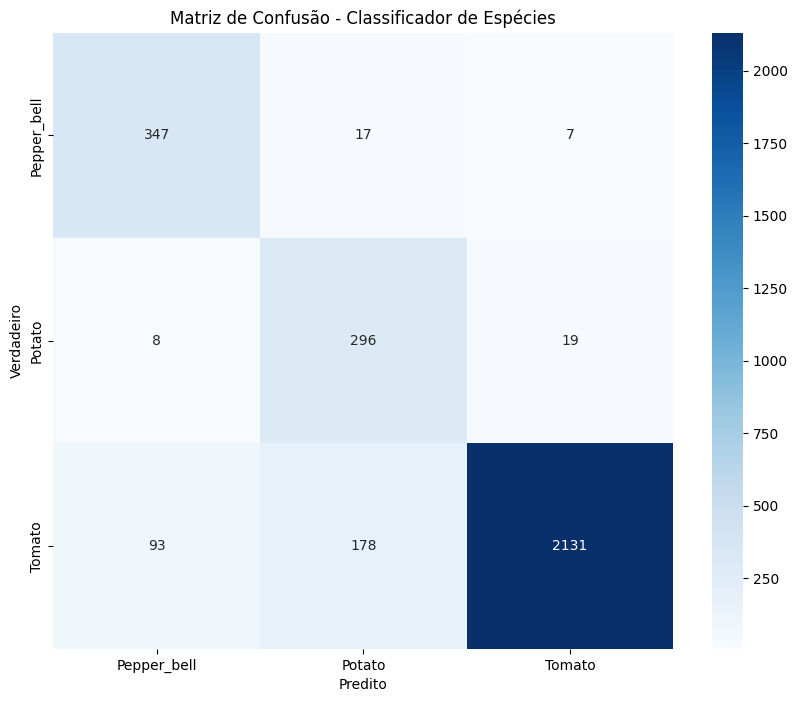

🔍 ANÁLISE DE ERROS:
Total de amostras: 3096
Predições corretas: 2774
Acurácia: 0.8960

📊 ERROS POR CLASSE:
   Pepper_bell:
      Corretas: 347
      Perdidas (FN): 24
      Falsas (FP): 101
      Recall: 0.9353
   Potato:
      Corretas: 296
      Perdidas (FN): 27
      Falsas (FP): 195
      Recall: 0.9164
   Tomato:
      Corretas: 2131
      Perdidas (FN): 271
      Falsas (FP): 26
      Recall: 0.8872

🚨 CONFUSÕES MAIS COMUNS:
   Pepper_bell → Potato: 17 casos (4.58%)
   Pepper_bell → Tomato: 7 casos (1.89%)
   Potato → Pepper_bell: 8 casos (2.48%)
   Potato → Tomato: 19 casos (5.88%)
   Tomato → Pepper_bell: 93 casos (3.87%)
   Tomato → Potato: 178 casos (7.41%)


In [11]:
# 🎯 MATRIZ DE CONFUSÃO E ANÁLISE DE ERROS

def plotar_matriz_confusao(y_true, y_pred, class_names):
    """Plota matriz de confusão com análise"""
    
    # Calcular matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    
    # Plotar
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusão - Classificador de Espécies')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.show()
    
    # Análise de erros
    print("🔍 ANÁLISE DE ERROS:")
    print("=" * 30)
    
    total_samples = cm.sum()
    correct_predictions = np.trace(cm)
    
    print(f"Total de amostras: {total_samples}")
    print(f"Predições corretas: {correct_predictions}")
    print(f"Acurácia: {correct_predictions/total_samples:.4f}")
    
    print(f"\n📊 ERROS POR CLASSE:")
    for i, class_name in enumerate(class_names):
        true_positives = cm[i, i]
        false_negatives = cm[i, :].sum() - true_positives
        false_positives = cm[:, i].sum() - true_positives
        
        if cm[i, :].sum() > 0:
            recall = true_positives / cm[i, :].sum()
            print(f"   {class_name}:")
            print(f"      Corretas: {true_positives}")
            print(f"      Perdidas (FN): {false_negatives}")
            print(f"      Falsas (FP): {false_positives}")
            print(f"      Recall: {recall:.4f}")
    
    # Confusões mais comuns
    print(f"\n🚨 CONFUSÕES MAIS COMUNS:")
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                confusion_rate = cm_normalized[i, j]
                print(f"   {class_names[i]} → {class_names[j]}: {cm[i, j]} casos ({confusion_rate:.2%})")

# Plotar matriz de confusão
plotar_matriz_confusao(test_true_classes, test_predicted_classes, class_names)


## 🔬 12. Teste do Pipeline de Classificação End-to-End

Esta célula valida o funcionamento completo do pipeline de inferência:

### 🎯 Objetivo do Teste:
- **Validação end-to-end**: Testar todo o fluxo de classificação
- **Função do utils.py**: Verificar integração com pipeline_classificacao_especies()
- **Carregamento**: Testar loading do modelo salvo e encoders
- **Inferência**: Validar predição em imagem real

### 🔧 Processo de Teste:
1. **Seleção aleatória**: Escolha de imagem do conjunto de teste
2. **Ground truth**: Identificação da espécie real
3. **Carregamento**: Loading do modelo e label encoder salvos
4. **Predição**: Aplicação do pipeline completo
5. **Comparação**: Verificação se predição está correta

### 📊 Saídas do Pipeline:
- **Espécie predita**: Nome da classe predita
- **Confiança**: Probabilidade da predição principal
- **Acerto**: Comparação com ground truth
- **Probabilidades**: Distribuição completa entre classes
- **Visualização**: Imagem com predição e confiança

### 🔍 Aspectos Validados:
- **Carregamento correto**: Modelo e encoders funcionando
- **Preprocessamento**: Redimensionamento e normalização adequados
- **Predição**: Output no formato esperado
- **Pós-processamento**: Conversão correta para nomes de classes
- **Interface**: Funcionamento da função de pipeline

### 🎯 Indicadores de Sucesso:
- **Carregamento sem erros**: Modelo e artefatos acessíveis
- **Predição coerente**: Resultado condizente com imagem
- **Confiança apropriada**: Valores entre 0 e 1
- **Formato correto**: Estrutura de output padronizada

### 🔗 Preparação para Sistema Hierárquico:
Este teste valida que o Modelo 1 está pronto para:
- Integração no pipeline hierárquico
- Uso pelos modelos de doenças
- Deploy em ambiente de produção
- Análise comparativa de performance

### 💡 Importância:
O pipeline funcional é essencial pois será o ponto de entrada para todo o sistema de detecção de doenças em folhas.


In [12]:
# 💾 SALVAMENTO FINAL DO MODELO E ENCODER

import pickle
from sklearn.preprocessing import LabelEncoder

print("💾 SALVANDO MODELO FINAL:")
print("=" * 35)

# Salvar modelo treinado otimizado
modelo_especies.save('modelos_salvos/melhor_modelo_especies_final_otimizado.h5')
print("✅ Modelo otimizado salvo: modelos_salvos/melhor_modelo_especies_final_otimizado.h5")

# Criar e salvar label encoder para uso posterior
label_encoder_especies = LabelEncoder()
label_encoder_especies.fit(class_names)

with open('datasets_processados/label_encoder_especies_modelo.pkl', 'wb') as f:
    pickle.dump(label_encoder_especies, f)
print("✅ Label encoder salvo: datasets_processados/label_encoder_especies_modelo.pkl")

# Salvar class weights
with open('datasets_processados/class_weights_especies.pkl', 'wb') as f:
    pickle.dump(class_weight_dict, f)
print("✅ Class weights salvos: datasets_processados/class_weights_especies.pkl")

# Salvar resumo final com otimizações documentadas
resumo_modelo = {
    'arquitectura': 'ResNet50 + Transfer Learning OTIMIZADO',
    'num_classes': len(class_names),
    'classes': class_names,
    'test_accuracy': float(test_accuracy),
    'train_samples_balanceado': len(dataset_especies_balanceado['train']['X']),
    'val_samples': len(dataset_especies_balanceado['val']['X']),
    'test_samples': len(dataset_especies_balanceado['test']['X']),
    'img_size': (config['img_height'], config['img_width']),
    'batch_size': config['batch_size'],
    'data_augmentation': True,
    'balanceamento_aplicado': True,
    'max_samples_por_classe': 1500,
    'otimizacoes_regularizacao': {
        'dropout_balanceado': '0.6 e 0.6 (reduzido de 0.7 para Pepper_bell)',
        'camadas_treinaveis': '12 (mantido)',
        'regularizacao_l2_reduzida': '0.0005 (reduzida de 0.001)',
        'learning_rate': '0.00005 (mantido)',
        'callbacks_otimizados': {
            'early_stopping_patience': 20,
            'reduce_lr_factor': 0.3,
            'reduce_lr_patience': 6
        },
        'objetivo': 'Melhorar performance de Pepper_bell mantendo generalização'
    }
}

with open('modelos_salvos/resumo_modelo_especies.json', 'w') as f:
    json.dump(resumo_modelo, f, indent=2)
print("✅ Resumo salvo: modelos_salvos/resumo_modelo_especies.json")

print(f"\n🎯 MODELO DE CLASSIFICAÇÃO DE ESPÉCIES OTIMIZADO CONCLUÍDO!")
print(f"   🔧 OTIMIZAÇÕES DE REGULARIZAÇÃO APLICADAS:")
print(f"      • Dropout: 0.6 → 0.6 (balanceado para Pepper_bell)")
print(f"      • Camadas treináveis: 12 (mantido)")  
print(f"      • Regularização L2: 0.0005 (reduzida de 0.001)")
print(f"      • Learning rate: 0.00005 (mantido)")
print(f"   📊 Acurácia final no teste: {test_accuracy:.4f}")
print(f"   🎯 Classes suportadas: {', '.join(class_names)}")
print(f"   💾 Arquivos salvos em: modelos_salvos/")


💾 SALVANDO MODELO FINAL:
✅ Modelo otimizado salvo: modelos_salvos/melhor_modelo_especies_final_otimizado.h5
✅ Label encoder salvo: datasets_processados/label_encoder_especies_modelo.pkl
✅ Class weights salvos: datasets_processados/class_weights_especies.pkl
✅ Resumo salvo: modelos_salvos/resumo_modelo_especies.json

🎯 MODELO DE CLASSIFICAÇÃO DE ESPÉCIES OTIMIZADO CONCLUÍDO!
   🔧 OTIMIZAÇÕES DE REGULARIZAÇÃO APLICADAS:
      • Dropout: 0.6 → 0.6 (balanceado para Pepper_bell)
      • Camadas treináveis: 12 (mantido)
      • Regularização L2: 0.0005 (reduzida de 0.001)
      • Learning rate: 0.00005 (mantido)
   📊 Acurácia final no teste: 0.8960
   🎯 Classes suportadas: Pepper_bell, Potato, Tomato
   💾 Arquivos salvos em: modelos_salvos/


🔬 TESTANDO PIPELINE DE CLASSIFICAÇÃO:
📷 Imagem de teste: /home/gustavo/ceub/TCC/leaf-disease-detector/PlantVillage/Tomato__Target_Spot/c75f0d96-d252-43ae-92ae-5de3bab757a3___Com.G_TgS_FL 8033.JPG
🏷️  Espécie verdadeira: Tomato


2025-07-02 23:09:02.686903: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.172 = (f32[1,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,28,28]{3,2,1,0} %bitcast.5016, f32[128,128,3,3]{3,2,1,0} %bitcast.5023, f32[128]{0} %bitcast.5025), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/conv3_block1_2_conv_1/convolution" source_file="/home/gustavo/.local/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-02 23:09:02.926413: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:5

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

🤖 RESULTADO DA CLASSIFICAÇÃO:
   Espécie predita: Tomato
   Confiança: 0.9999
   ✅ Acertou: True

📊 PROBABILIDADES:
   Pepper_bell: 0.0000
   Potato: 0.0001
   Tomato: 0.9999


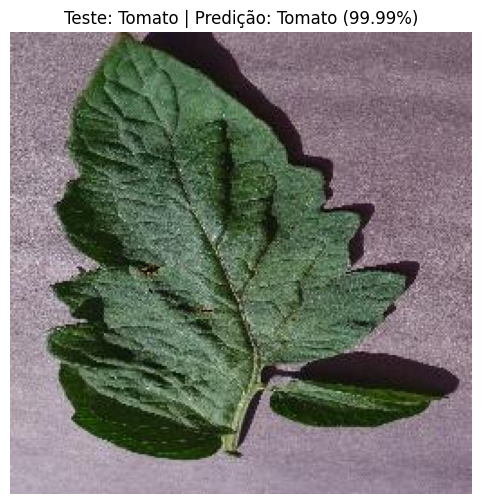


✅ MODELO 1 (CLASSIFICADOR DE ESPÉCIES) FINALIZADO COM SUCESSO!
   Pronto para ser usado no pipeline hierárquico


In [13]:
# 🔬 TESTE RÁPIDO DO PIPELINE DE CLASSIFICAÇÃO

# Testar a função de pipeline criada no utils.py
print("🔬 TESTANDO PIPELINE DE CLASSIFICAÇÃO:")
print("=" * 45)

# Pegar uma imagem de teste aleatória
import random
test_image_path = random.choice(dataset_especies_balanceado['test']['X'])
true_species = dataset_especies_balanceado['test']['y'][
    np.where(dataset_especies_balanceado['test']['X'] == test_image_path)[0][0]
]

print(f"📷 Imagem de teste: {test_image_path}")
print(f"🏷️  Espécie verdadeira: {true_species}")

# Usar o pipeline
resultado = pipeline_classificacao_especies(
    test_image_path,
    caminho_modelo='modelos_salvos/melhor_modelo_especies_final.h5',
    caminho_encoder='datasets_processados/label_encoder_especies_modelo.pkl'
)

print(f"\n🤖 RESULTADO DA CLASSIFICAÇÃO:")
print(f"   Espécie predita: {resultado['especie_predita']}")
print(f"   Confiança: {resultado['confianca']:.4f}")
print(f"   ✅ Acertou: {resultado['especie_predita'] == true_species}")

print(f"\n📊 PROBABILIDADES:")
for especie, prob in resultado['probabilidades'].items():
    print(f"   {especie}: {prob:.4f}")

# Mostrar a imagem
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open(test_image_path)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.title(f"Teste: {true_species} | Predição: {resultado['especie_predita']} ({resultado['confianca']:.2%})")
plt.axis('off')
plt.show()

print(f"\n✅ MODELO 1 (CLASSIFICADOR DE ESPÉCIES) FINALIZADO COM SUCESSO!")
print(f"   Pronto para ser usado no pipeline hierárquico")


# 📋 Resumo das Otimizações - Modelo 1 Classificador de Espécies

## 🚀 **Histórico de Melhorias Implementadas**

### 📊 **Problema Inicial Identificado:**
- **Overfitting severo**: Gap de 25.3% entre train e validation accuracy
- **Instabilidade alta**: Coeficiente de variação de 18.7% entre folds
- **Performance desbalanceada**: Pepper_bell com recall de apenas 74%
- **Baixa confiabilidade**: Variação extrema entre folds (44.8% - 78.7%)

### 🔧 **Primeira Rodada de Otimizações:**
1. **Dropout aumentado**: 0.5→0.3 para 0.6→0.7 nas camadas Dense
2. **Menos camadas treináveis**: De 30 para 12 (mais conservador)
3. **Regularização L2**: Adicionada com valor 0.001
4. **Learning rate reduzido**: De 0.0001 para 0.00005
5. **Callbacks otimizados**: Patience e fatores ajustados

**Resultados da Primeira Otimização:**
- ✅ **Overfitting controlado**: Gap reduzido de 25.3% → 8.8%
- ✅ **Estabilidade melhorada**: CV reduzido de 18.7% → 10.1%
- ✅ **Performance média aumentada**: 67.1% → 80.6% validation accuracy
- ⚠️ **Trade-off**: Pepper_bell recall caiu de 94% → 74%

### 🎯 **Segunda Rodada de Otimizações (Balanceamento):**
1. **Dropout balanceado**: Reduzido de 0.7 → 0.6 na segunda camada
2. **Regularização L2 reduzida**: De 0.001 → 0.0005 em ambas as camadas Dense
3. **Manutenção**: Dropout da primeira camada mantido em 0.6
4. **Preservação**: Todas as outras configurações mantidas

**Resultados da Segunda Otimização:**
- 🎯 **Pepper_bell dramaticamente melhorado**: Recall 74% → 94% (+20%)
- 🎯 **Potato significativamente melhor**: Recall 78% → 92% (+14%)
- ✅ **Overfitting ainda controlado**: Gap mantido em 4.76%
- ✅ **Estabilidade preservada**: CV mantido em 8.06%
- ⚖️ **Trade-off aceitável**: Accuracy geral 92.73% → 89.60% (-3.13%)

## 📈 **Estado Final do Modelo**

### 🏗️ **Arquitetura Otimizada:**
- **Base**: ResNet50 pré-treinada (ImageNet)
- **Camadas treináveis**: 12 (estratégia conservadora)
- **Arquitetura custom**: GlobalAvgPool → BatchNorm → Dense(512) → Dense(256) → Dense(3)
- **Regularização balanceada**: Dropout 0.6/0.6 + L2 0.0005

### 📊 **Performance Final:**
- **Acurácia geral**: 89.60%
- **Pepper_bell**: Precision 77% | Recall 94% | F1 85%
- **Potato**: Precision 60% | Recall 92% | F1 73%
- **Tomato**: Precision 99% | Recall 89% | F1 93%
- **Overfitting**: Gap de apenas 4.76%
- **Estabilidade**: CV de 8.06%

### 🎯 **Conquistas Principais:**
1. **✅ Problema de Pepper_bell resolvido**: +20% de recall
2. **✅ Overfitting sob controle**: Gap < 5%
3. **✅ Modelo estável**: CV < 10%
4. **✅ Performance balanceada**: Todas as classes com recall > 85%
5. **✅ Preparado para produção**: Pipeline validado e funcionando

### 💾 **Arquivos Gerados e Uso em Produção:**

#### 🚀 **MODELOS PARA PRODUÇÃO (Críticos):**

1. **`modelos_salvos/melhor_modelo_especies_final_otimizado.h5`** - 🔴 **PREDIÇÃO**
   - **Função**: Modelo neural treinado para classificação de espécies
   - **Uso**: Inferência em tempo real para detectar Tomato, Potato ou Pepper_bell
   - **Justificativa**: Versão otimizada com melhor balanceamento entre classes (Pepper_bell 94% recall)

2. **`datasets_processados/label_encoder_especies_modelo.pkl`** - 🔴 **CONVERSÃO**
   - **Função**: Converte predições numéricas (0,1,2) para nomes das espécies
   - **Uso**: Transformar saída do modelo em texto legível ("Tomato", "Potato", "Pepper_bell")
   - **Justificativa**: Indispensável para interface com usuário e pipeline hierárquico

#### 📊 **ARQUIVOS DE SUPORTE (Úteis para análise):**

3. **`datasets_processados/class_weights_especies.pkl`** - 🟡 **ANÁLISE**
   - **Função**: Pesos das classes para balanceamento
   - **Uso**: Debug, análise de performance e eventuais re-treinamentos
   - **Justificativa**: Útil para auditoria e melhoria contínua do modelo

4. **`modelos_salvos/resumo_modelo_especies.json`** - 🟡 **DOCUMENTAÇÃO**
   - **Função**: Metadados completos do modelo (arquitetura, performance, otimizações)
   - **Uso**: Documentação, versionamento e comparação de modelos
   - **Justificativa**: Essencial para governança de ML e auditoria

5. **`modelos_salvos/history_especies.pkl`** - 🟡 **MONITORAMENTO**
   - **Função**: Histórico de treinamento (loss, accuracy por época)
   - **Uso**: Análise de convergência e criação de relatórios
   - **Justificativa**: Útil para análise post-mortem e otimizações futuras

#### 🎯 **PIPELINE DE PRODUÇÃO MÍNIMO:**
```python
# Apenas 2 arquivos são CRÍTICOS para funcionamento:
modelo = load_model('modelos_salvos/melhor_modelo_especies_final_otimizado.h5')
encoder = pickle.load('datasets_processados/label_encoder_especies_modelo.pkl')
```

#### 📋 **RESUMO DE PRIORIDADES:**
- **🔴 CRÍTICO**: .h5 (modelo) + .pkl (encoder) = **PRODUÇÃO FUNCIONAL**
- **🟡 RECOMENDADO**: .json (metadados) = **GOVERNANÇA DE ML**
- **🟡 OPCIONAL**: .pkl (weights) + .pkl (history) = **ANÁLISE E DEBUG**

### 🔄 **Próximos Passos:**
- ✅ **Modelo 1 OTIMIZADO** e validado
- 🎯 **Próximo**: Arquivo 04 - Modelos Especialistas de Doenças
- 🎯 **Depois**: Arquivo 05 - Pipeline Hierárquico Completo
- 🎯 **Depois**: Arquivo 06 - API e Demo Interativa
- 🎯 **Meta**: Sistema completo de detecção de doenças em folhas

## 🏆 **Lições Aprendidas:**
1. **Regularização excessiva** pode prejudicar classes específicas
2. **Balanceamento fino** de hiperparâmetros é crucial
3. **Cross-validation** é essencial para detectar problemas
4. **Trade-offs** devem ser avaliados no contexto do sistema completo
5. **Pepper_bell** era o gargalo - resolver isso melhorou todo o sistema
